In [1]:
import pgmpy as pg
from pgmpy.readwrite import BIFReader
import networkx as nx
from pgmpy.models import BayesianModel, BayesianNetwork
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pgmpy.estimators import HillClimbSearch, K2Score, ExhaustiveSearch, BicScore, BDeuScore, BDsScore, MmhcEstimator, BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import itertools

In [2]:
def draw_graph(model,name):
    p = graphviz_layout(model, prog="dot")
    plt.figure(figsize=(15, 8))
    nx.draw(model, with_labels=True, pos=p, node_size=1400, node_color="green", font_size=6)
    plt.savefig(name+'.png')
    plt.show()

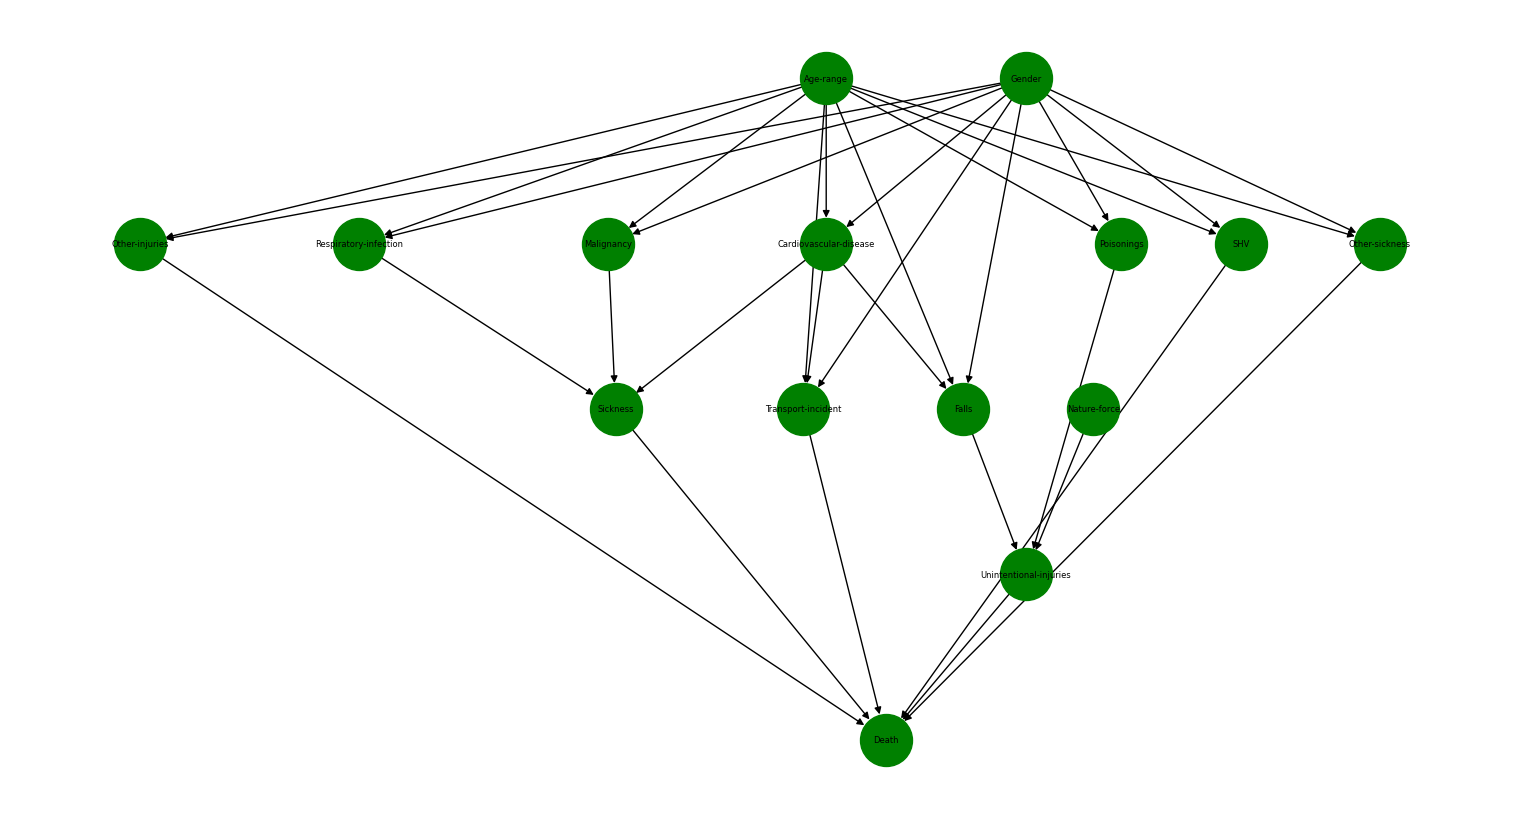

In [4]:
# Manual constructed model
mc_model = BayesianNetwork([
    ('Age-range', 'Other-injuries'), 
    ('Age-range', 'Falls'), 
    ('Age-range', 'Poisonings'), 
    ('Age-range', 'Transport-incident'), 
    ('Age-range', 'SHV'), 
    ('Age-range', 'Respiratory-infection'),
    ('Age-range', 'Malignancy'), 
    ('Age-range', 'Other-sickness'), 
    ('Age-range', 'Cardiovascular-disease'),
    ('Gender', 'Other-injuries'), 
    ('Gender', 'Falls'), 
    ('Gender', 'Poisonings'), 
    ('Gender', 'Transport-incident'), 
    ('Gender', 'SHV'), 
    ('Gender', 'Respiratory-infection'),
    ('Gender', 'Malignancy'), 
    ('Gender', 'Other-sickness'), 
    ('Gender', 'Cardiovascular-disease'),
    ('Cardiovascular-disease', 'Falls'), 
    ('Cardiovascular-disease','Transport-incident'),
    ('Cardiovascular-disease', 'Sickness'),
    ('Other-injuries', 'Death'),
    ('Unintentional-injuries','Death'),
    ('Falls', 'Unintentional-injuries'), 
    ('Poisonings', 'Unintentional-injuries'), 
    ('Nature-force', 'Unintentional-injuries'), 
    ('Transport-incident', 'Death'), 
    ('SHV', 'Death'), 
    ('Respiratory-infection', 'Sickness'), 
    ('Malignancy', 'Sickness'), 
    ('Other-sickness', 'Death'),
    ('Sickness', 'Death')
])

draw_graph(mc_model,"mc_model")

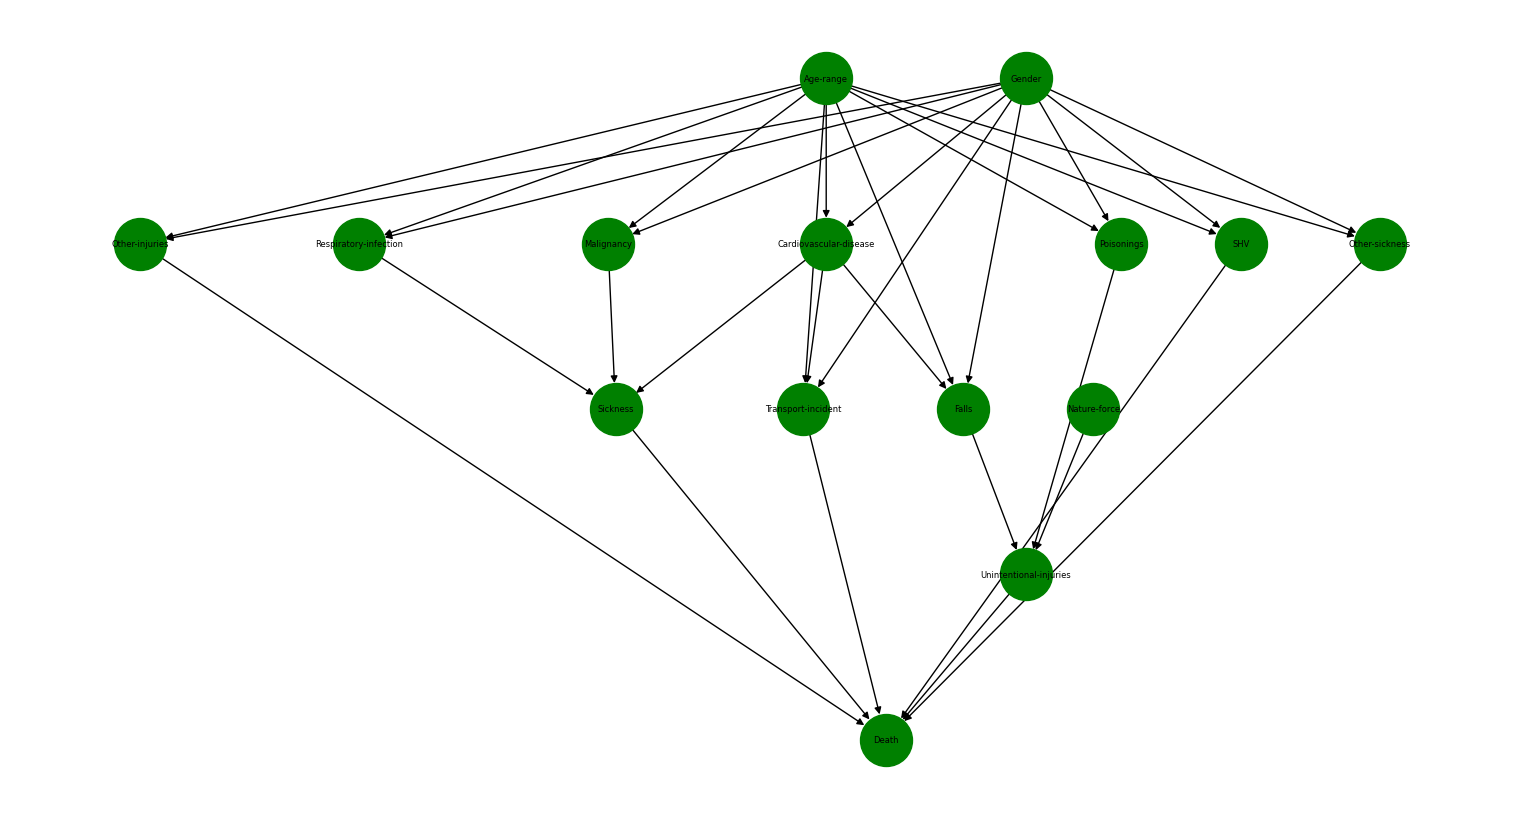

In [5]:
# Manual constructed model + Covid
mc_model_Covid = BayesianNetwork([
    ('Age-range', 'Other-injuries'), 
    ('Age-range', 'Falls'), 
    ('Age-range', 'Poisonings'), 
    ('Age-range', 'Transport-incident'), 
    ('Age-range', 'SHV'), 
    ('Age-range', 'Respiratory-infection'),
    ('Age-range', 'Malignancy'), 
    ('Age-range', 'Other-sickness'), 
    ('Age-range', 'Cardiovascular-disease'),
    ('Age-range', 'Covid'),
    ('Gender', 'Other-injuries'), 
    ('Gender', 'Falls'), 
    ('Gender', 'Poisonings'), 
    ('Gender', 'Transport-incident'), 
    ('Gender', 'SHV'), 
    ('Gender', 'Respiratory-infection'),
    ('Gender', 'Malignancy'), 
    ('Gender', 'Other-sickness'), 
    ('Gender', 'Cardiovascular-disease'),
    ('Gender', 'Covid'),
    ('Covid', 'Respiratory-infection'),
    ('Cardiovascular-disease', 'Falls'), 
    ('Cardiovascular-disease','Transport-incident'),
    ('Cardiovascular-disease', 'Sickness'),
    ('Other-injuries', 'Death'),
    ('Unintentional-injuries','Death'),
    ('Falls', 'Unintentional-injuries'), 
    ('Poisonings', 'Unintentional-injuries'), 
    ('Nature-force', 'Unintentional-injuries'), 
    ('Transport-incident', 'Death'), 
    ('SHV', 'Death'), 
    ('Respiratory-infection', 'Sickness'), 
    ('Malignancy', 'Sickness'), 
    ('Other-sickness', 'Death'),
    ('Sickness', 'Death')
])

draw_graph(mc_model,"mc_model")

In [6]:
# Data retrieving using Bif file and dataset construction

data = BIFReader("./data/probabilities.bif")

In [7]:
# Dataset automatic construction and retrieving
#from imp import reload
#import data.datasetConstructor
#reload(data.datasetConstructor)

#sdata.datasetConstructor.datasetConstructor()

dataset = pd.read_csv("./data/dataset.csv")

#dataset.info()

dataset.head()



,ID,Age-range,Gender,Falls,Poisonings,Nature-force,Cardiovascular-disease,Malignancy,Respiratory-infection,Transport-incident,Sickness,Other-injuries,Unintentional-injuries,Other-sickness,SHV,Death
0,1,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,young,female,0,0,0,0,0,1,0,0,0,0,0,0,0
4,5,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Creation of a compressed dataset grouping data for age-range

compressed_dataset = dataset.drop("ID",axis=1).groupby(["Age-range","Gender"]).sum()
compressed_dataset.head(6)

Falls  Poisonings  Nature-force  Cardiovascular-disease  \
Age-range Gender                                                            
adult     female  18976        2364          4295                    2543   
          male    25033        2759          4235                   14316   
old       female   5115         137           564                    1473   
          male     6893         137           582                     790   
young     female  22056        1316          2296                     587   
          male    28027        2379          2206                   13513   

                  Malignancy  Respiratory-infection  Transport-incident  \
Age-range Gender                                                          
adult     female       19442                  55050               17170   
          male         23722                  43627               29570   
old       female        6853                  10143                1172   
          male          8234                   8263                1635   
young     female         392                  65894                2428   
          male           397                  53516                3248   

                  Sickness  Other-injuries  Unintentional-injuries  \
Age-range Gender                                                     
adult     female       780              24                      26   
          male        1179              59                      29   
old       female       205              11                       7   
          male         221              17                      14   
young     female       439             153                      31   
          male         824              23                      40   

                  Other-sickness   SHV  Death  
Age-range Gender                               
adult     female             325  3415   3443  
          male               855  7280   6195  
old       female             620   329    399  
          male               650   725    526  
young     female             355    26    606  
          male               453    64    812

In [9]:
columns = ["Falls","Poisonings","Nature-force","Cardiovascular-disease","Malignancy","Respiratory-infection","Transport-incident","Sickness","Other-injuries","Unintentional-injuries","Other-sickness","SHV","Death"]
index = ["male","female"]

young = np.array(compressed_dataset.drop(["old","adult"]))
adult = np.array(compressed_dataset.drop(["young","old"]))
old = np.array(compressed_dataset.drop(["young","adult"]))

dataYoung = pd.DataFrame(young,index=index, columns=columns)
dataAdult = pd.DataFrame(adult,index=index, columns=columns)
dataOld = pd.DataFrame(old,index=index, columns=columns)


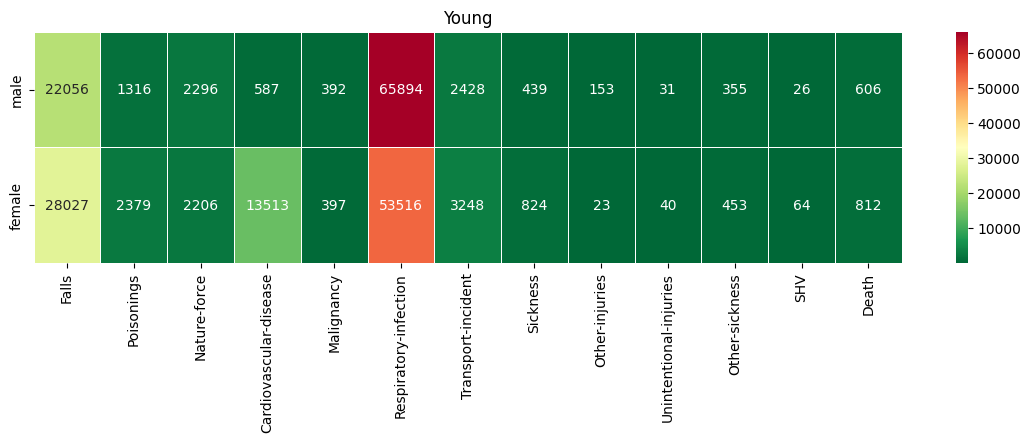

In [10]:
plt.figure(figsize=(14,3))
sns.heatmap(dataYoung, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Young")
print()

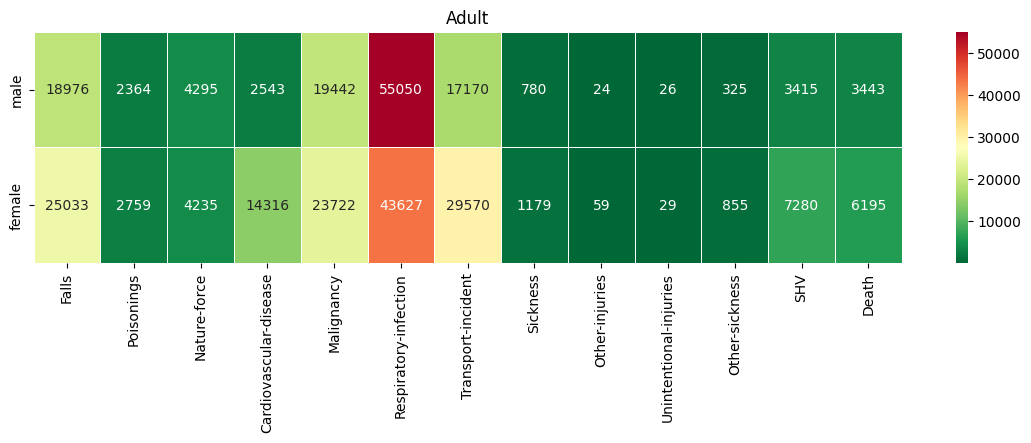

In [11]:
plt.figure(figsize=(14,3))
sns.heatmap(dataAdult, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Adult")
print()

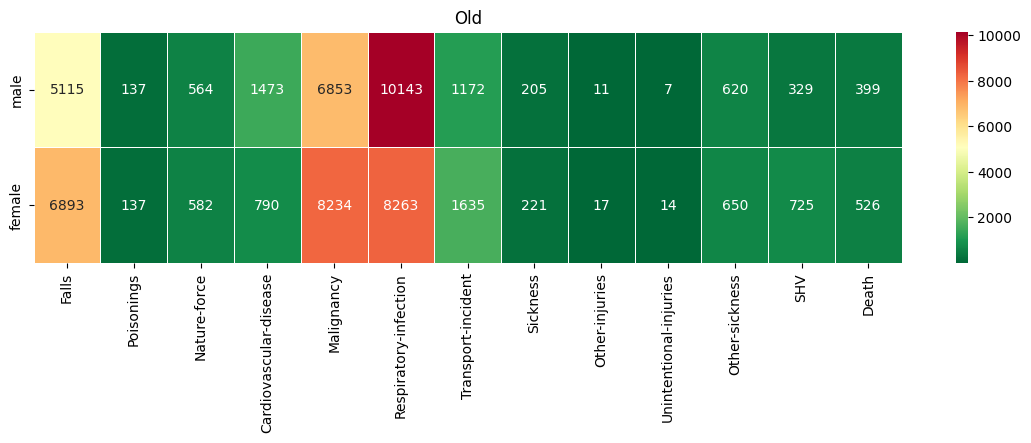

In [12]:
plt.figure(figsize=(14,3))
sns.heatmap(dataOld, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Old")
print()

In [28]:
# estimator = HillClimbSearch(dataset.drop(np.arange(500,10000,9500)))

# hillclimb_model = estimator.estimate( scoring_method=BDsScore(dataset) )
# hillclimb_model = BayesianNetwork(hillclimb_model)
# draw_graph(hillclimb_model,"hillclimb_model")

In [13]:
# Parameter estimation on manual model




In [95]:
mc_model.cpds = []

d = data=dataset.drop("ID",axis=1)

mc_model.fit(data=d,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

print(f"Check model: {mc_model.check_model()=}")

for cpd in mc_model.get_cpds():
    print(f"CPT of {cpd.variable}")
    print(cpd)
    # fig, ax1 = plt.subplots(figsize=(len(targets_combinations), len(targets)+len(models)))
    # table = ax1.table(cellText = rows,
    #                   cellLoc = "center",
    #                   colLabels = col_labels,
    #                   colColours = col_colours,
    #                   loc = "center")
    
    # for i in range(1, len(rows)+1):
    #     if not i%2:
    #         for j in range(0, len(targets) + len(models)):
    #             table[(i, j)].set_facecolor("#dbdbdb")

    # table.scale(2, 2)
    # table.set_fontsize(12)
    # ax1.axis("off")
    # ax1.set_title(title)
    pass

Check model: mc_model.check_model()=True
CPT of Age-range
+------------------+-----------+
| Age-range(adult) | 0.599497  |
+------------------+-----------+
| Age-range(old)   | 0.0817035 |
+------------------+-----------+
| Age-range(young) | 0.318799  |
+------------------+-----------+
CPT of Other-injuries
+-------------------+-----+------------------------+
| Age-range         | ... | Age-range(young)       |
+-------------------+-----+------------------------+
| Gender            | ... | Gender(male)           |
+-------------------+-----+------------------------+
| Other-injuries(0) | ... | 0.9998516994414357     |
+-------------------+-----+------------------------+
| Other-injuries(1) | ... | 0.00014830055856420167 |
+-------------------+-----+------------------------+
CPT of Falls
+------------------------+-----+---------------------------+
| Age-range              | ... | Age-range(young)          |
+------------------------+-----+---------------------------+
| Cardiovascular

CPT of Age-range
CPT of Other-injuries
CPT of Falls
CPT of Poisonings
CPT of Transport-incident
CPT of SHV
CPT of Respiratory-infection
CPT of Malignancy
CPT of Other-sickness
CPT of Cardiovascular-disease
CPT of Gender
CPT of Sickness
CPT of Death
CPT of Unintentional-injuries
CPT of Nature-force


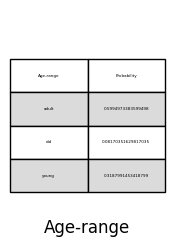

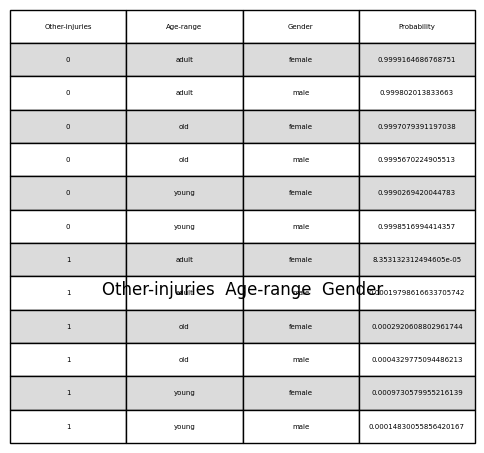

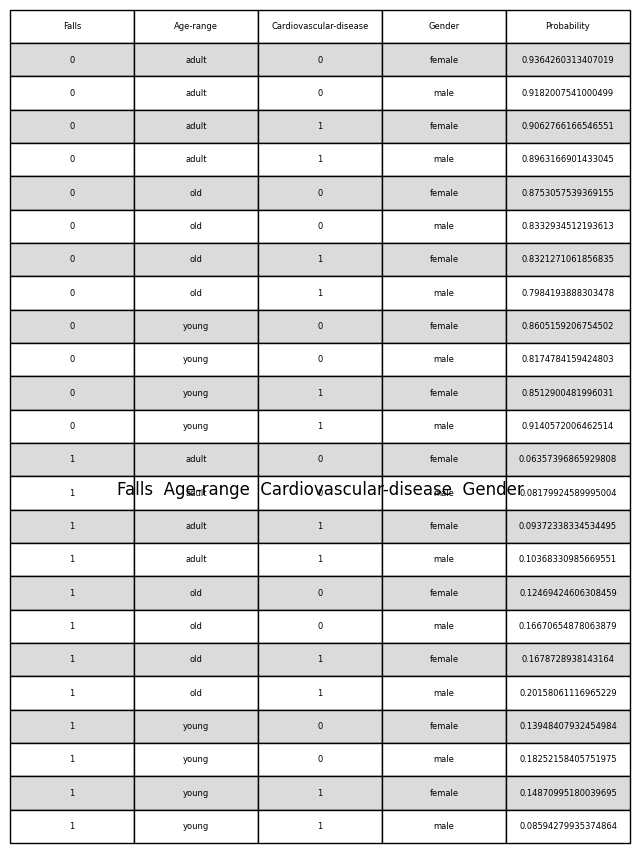

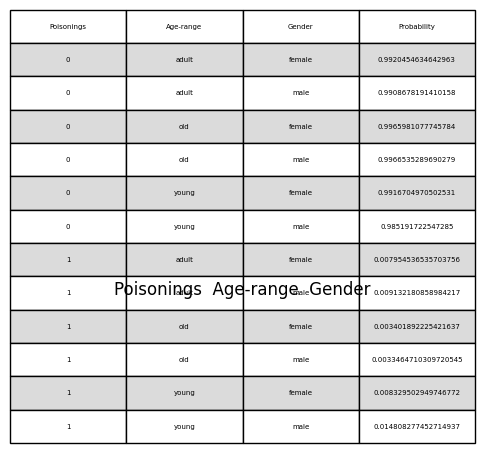

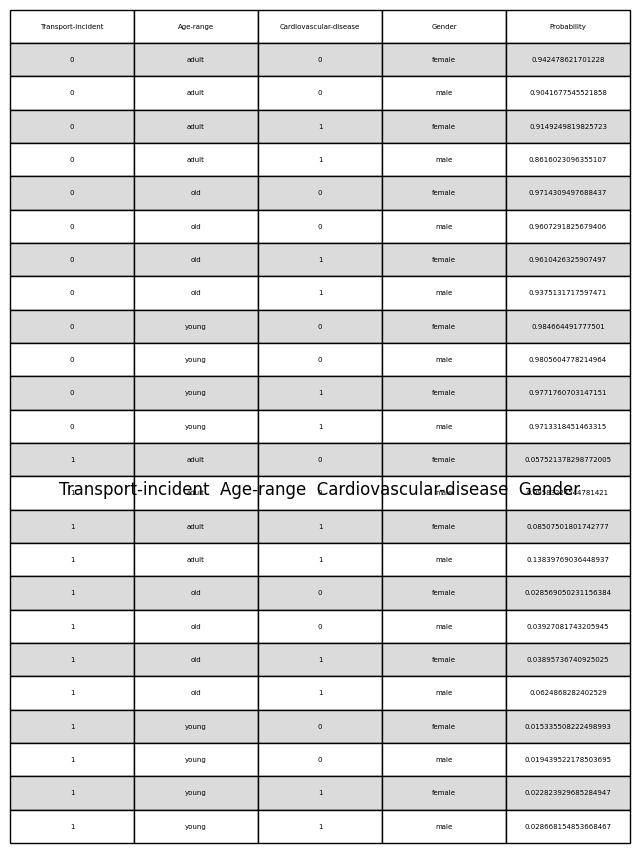

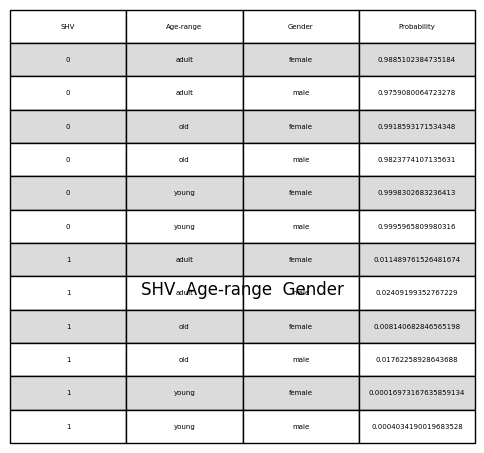

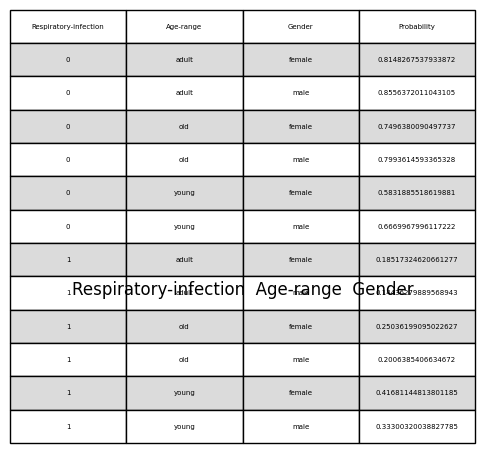

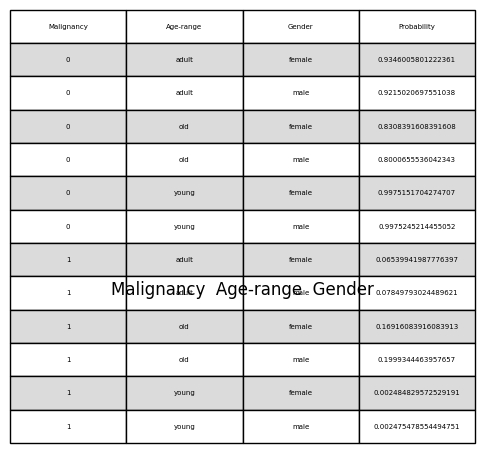

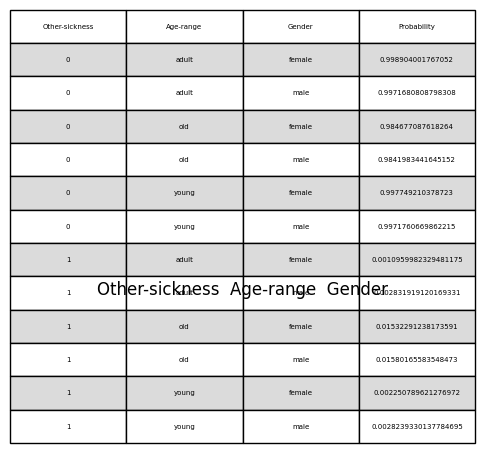

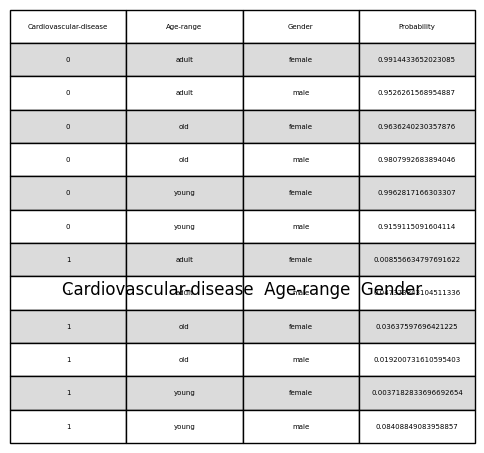

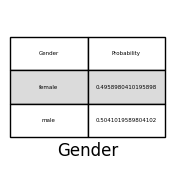

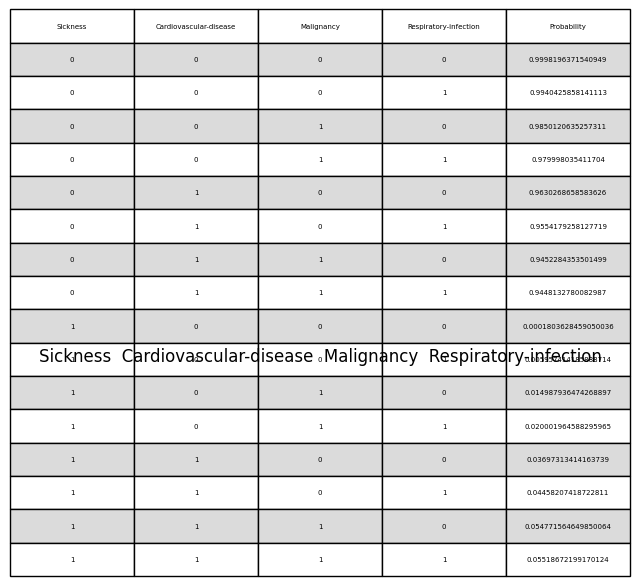

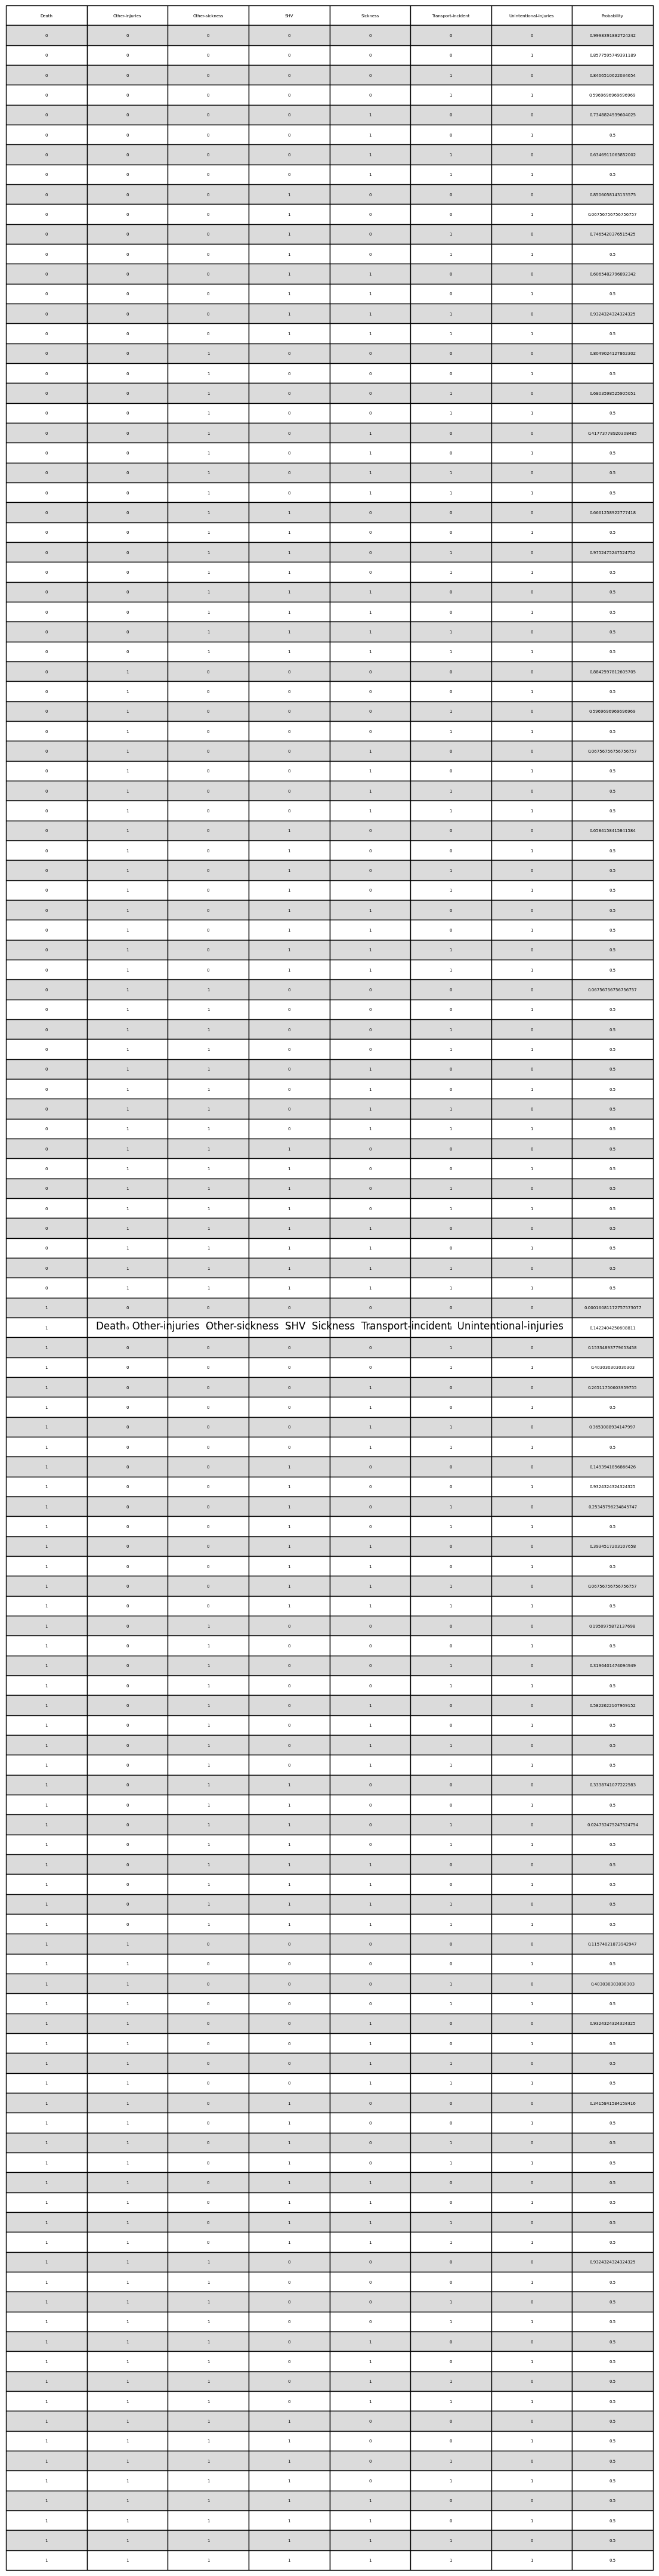

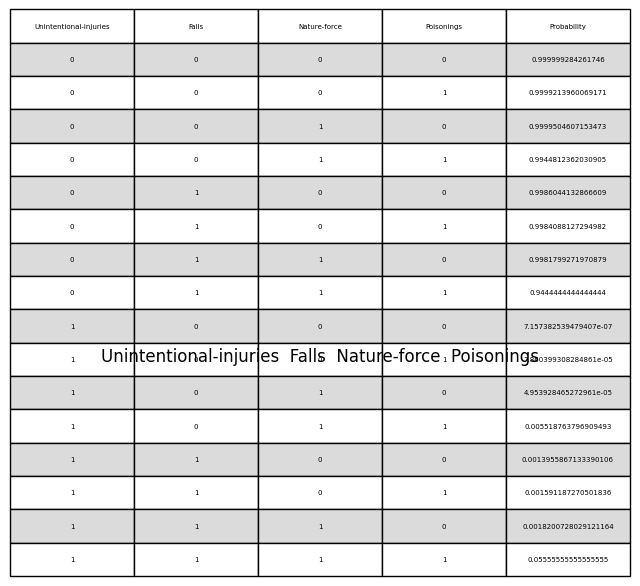

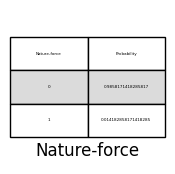

In [144]:
for cpd in mc_model.get_cpds():
    # print(f"CPT of {cpd.variable}")
    # print(cpd.state_names)
    # if hasattr(cpd, "evidence"):
    #         print(cpd.evidence)
    states_list = []
    for variable in cpd.state_names.keys():
        states_list.append(cpd.state_names[variable])
    rows = []
    i= 0
    states_combos = list(itertools.product(*states_list))
    values = cpd.values.flatten()

    for combo in states_combos:
        items = zip(cpd.state_names, combo)
        row = []
        for item in items:
            row += [str(item[1])]
        row += [str(values[i])]
        rows.append(row)
        i+=1

    col_labels = []
    for state in cpd.state_names.keys():
        col_labels+= [state]
    col_labels += ["Probability"]
    fig, ax1 = plt.subplots(figsize=(len(cpd.state_names.keys()), len(cpd.state_names[cpd.variable])))
    table = ax1.table(cellText = rows,
                      cellLoc = "center",
                      colLabels = col_labels,
                      loc = "center")
    
    for i in range(1, len(rows)+1):
        if i%2:
            for j in range(0, len(cpd.state_names.keys())+1):
                table[(i, j)].set_facecolor("#dbdbdb")

    table.scale(2, 2)
    table.set_fontsize(16)
    ax1.axis("off")
    ax1.set_title('  '.join(cpd.state_names.keys()), y = 0)
    pass

In [15]:

def getPossibleGroups(evidences):
    values = []
    for evidence in evidences:
        values.append(evidence["values"])
    return list(itertools.product(*values))

# elements: array of tuples where the first element is the node of the query and the other elements are the evidences to use

def completeQueriesGenerator(model,elements):
    all_states = model.states
    all_queries = []
    for element in elements:
        node = element[0]
        queries = []
        evidences = []
        for i in range(1,len(element)):
            evidences.append({"evidence":element[i],"values":all_states[element[i]]})

        groups = getPossibleGroups(evidences)
        for group in groups: 
            evidences_obj = {}
            for evidence_value in zip(evidences, group): 
                curr_key = evidence_value[0]['evidence']
                evidences_obj[curr_key] = evidence_value[1]
            queries.append(([node], evidences_obj))        
        all_queries = all_queries + queries
    return all_queries

#q = completeQueriesGenerator(mc_model,(("Other-injuries","Age-range","Gender"),))

In [79]:
allStates = mc_model.states

# Inference
def inference(model, target, evidence):
    model_inference = VariableElimination(model)
    return model_inference.query(target, evidence)


def plot_query_table(models, targets, evidence):
    model_to_phi = {}
    names = []
    for model in models:
        model_to_phi[model] = inference(model.model, targets, evidence)
        names.append(model.name)

    targets_values = {}
    for target in targets:
        targets_values[target] = allStates[target]

    table_data = []
    combinations = list(itertools.product(*targets_values.values()))
    for combination in combinations:
        row_data = [*combination]

        for model in models:
            prob = round(model_to_phi[model].get_value(**dict(zip(targets_values.keys(), combination))), 4)
            row_data += [prob]

        table_data.append(row_data)

    fig, ax1 = plt.subplots(figsize=(len(combinations), len(targets) + len(models)))

    ccolors = np.full(len(targets) + len(models), "lavender")

    table = ax1.table(cellText=table_data,
                      cellLoc = "center",
                      colLabels= targets + names,
                      colColours = ccolors,
                      loc="center"
                      )

    table.scale(2,2)
    table.set_fontsize(12)
    ax1.axis("off")

    title = f"P({', '.join(targets)} | {', '.join([f'{k}={v}' for (k, v) in evidence.items()])})"

    ax1.set_title(title)


    #return tables

def plot_tables(models, targets, evidences):
    title = f"P({', '.join(targets)} | {', '.join([f'{key}={value}' for (key, value) in evidences.items()])})"
    
    model_names = [model.name for model in models]
    col_labels = targets + model_names

    col_colours = np.full(len(targets) + len(models), "#80bc99")

    targets_values = {}
    for target in targets:
        targets_values[target] = mc_model.states[target]

    query_by_model = {}
    for model in models:
        query_by_model[model] = inference(model.model, targets, evidences)

    rows = []
    targets_combinations = list(itertools.product(*targets_values.values()))
    for combo in targets_combinations:
        row = [*combo]
        combo_queries = [round(query_by_model[this_model].get_value(**dict(zip(targets_values.keys(), combo))), 4) for this_model in query_by_model.keys()] 
        row += combo_queries
        rows.append(row)
    
    fig, ax1 = plt.subplots(figsize=(len(targets_combinations), len(targets)+len(models)))
    table = ax1.table(cellText = rows,
                      cellLoc = "center",
                      colLabels = col_labels,
                      colColours = col_colours,
                      loc = "center")
    
    for i in range(1, len(rows)+1):
        if not i%2:
            for j in range(0, len(targets) + len(models)):
                table[(i, j)].set_facecolor("#dbdbdb")

    table.scale(2, 2)
    table.set_fontsize(12)
    ax1.axis("off")
    ax1.set_title(title)



In [29]:
def print_queries(model, queries):
    handWrittenQueries = [
        #(["X"], {"evidence": "value"}),   
    ]
    queries = queries + handWrittenQueries
    for query in queries:
        plot_tables(model, *query)

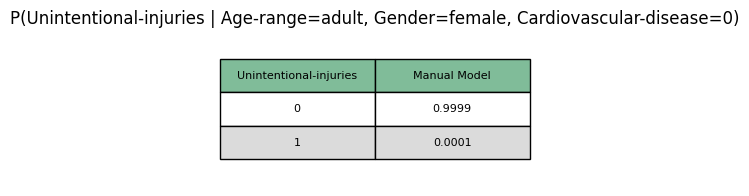

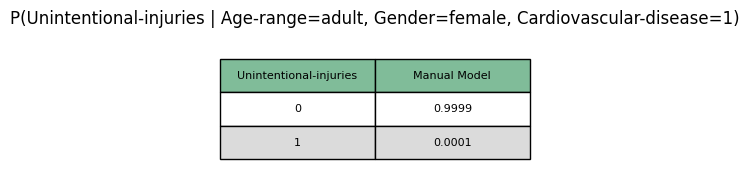

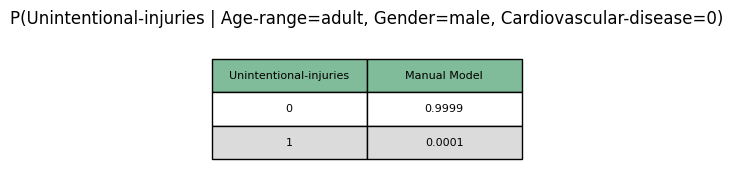

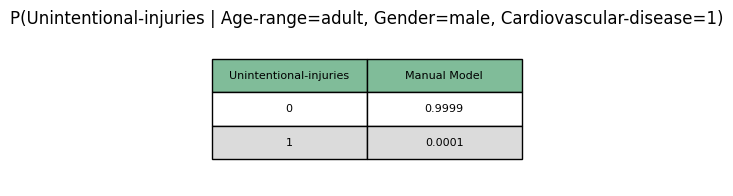

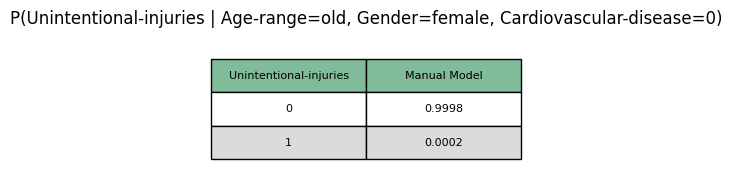

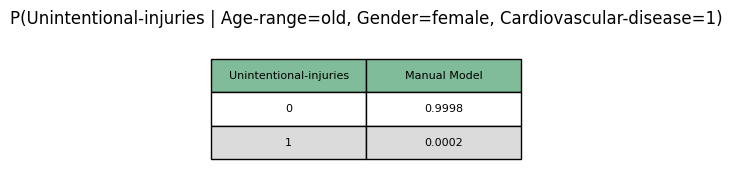

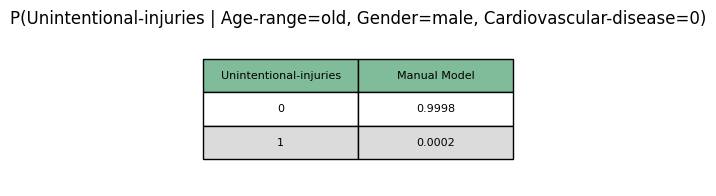

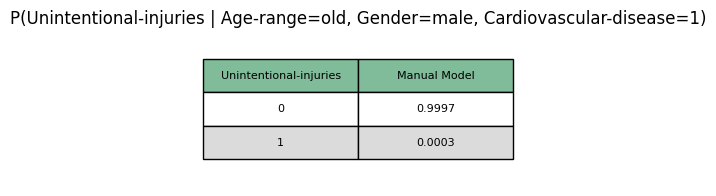

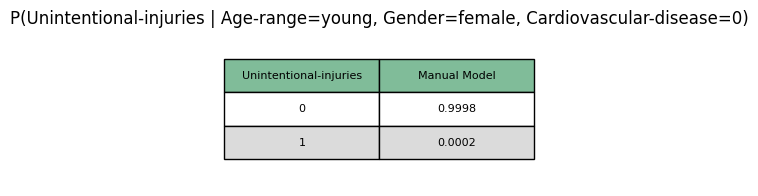

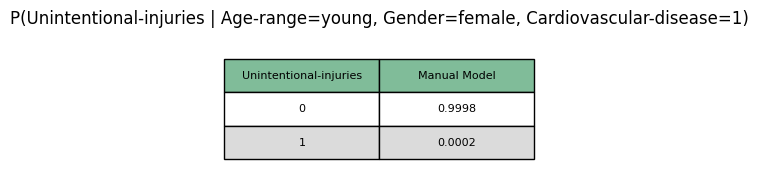

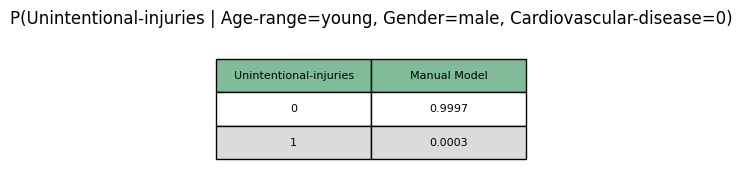

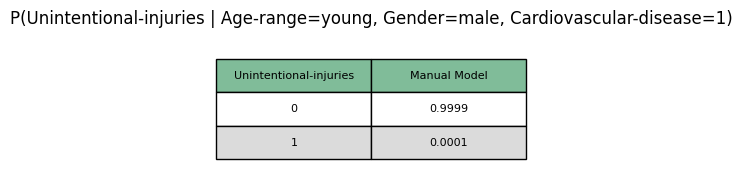

In [80]:
class Model:
    def __init__(self, model, name, dataset):
        self.model = model
        self.name = name
        self.dataset = dataset

models = [
    Model(model=mc_model, name="Manual Model", dataset=dataset),
    #Model(model=hillclimb_model, name="HillClimb Model", dataset=dataset),
]

q = completeQueriesGenerator(mc_model,(("Unintentional-injuries","Age-range","Gender","Cardiovascular-disease"),))
print_queries(models, q)